In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle 

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)

2.6.0


In [118]:
df = pd.read_pickle('bpm_big_data_ex_std.plk') 

In [119]:
df

,bunch_charge,num_bunches,V125,H125,connection,reps,C1,C2,C3,C4,...,B605PH_std,B605PV_std,B609PH_std,B609PV_std,B610PH_std,B610PV_std,B612PH_std,B612PV_std,B613PH_std,B613PV_std
0,250,50,-0.3452,0.5357,Upstream,300,0.125787,0.130386,0.523158,0.448682,...,242.156789,219.597515,161.013838,157.417929,213.004640,157.617959,246.976467,241.559555,189.946300,142.303250
1,250,50,-0.3452,0.5357,Upstream,300,0.124891,0.122449,0.504881,0.429264,...,288.396030,216.088618,139.333850,156.589939,192.881741,140.235060,241.478883,222.563772,160.001185,165.372739
2,250,50,-0.3452,0.5357,Upstream,300,0.124635,0.120322,0.505017,0.427904,...,333.283321,164.506662,150.401965,148.781042,230.306773,170.802851,260.509903,204.933165,179.676109,150.015966
3,250,50,-0.3452,0.5357,Upstream,300,0.118786,0.116632,0.478015,0.401456,...,337.385941,210.200329,146.325961,157.866857,174.420867,174.777828,288.771241,206.283748,192.492028,162.731326
4,250,50,-0.3452,0.5357,Upstream,300,0.133275,0.131215,0.530097,0.450509,...,320.810397,219.806615,147.005299,175.304348,198.113168,175.360509,222.726873,192.976742,175.453032,139.124687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17595,250,1,0.0000,-1.0000,Downstream,300,0.164531,0.213478,0.194903,0.181066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17596,250,1,0.0000,-1.0000,Downstream,300,0.150945,0.206443,0.184874,0.175678,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17597,250,1,0.0000,-1.0000,Downstream,300,0.144606,0.196726,0.178423,0.168635,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17598,250,1,0.0000,-1.0000,Downstream,300,0.144625,0.196734,0.177356,0.169459,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


378.81155155181887
27605.345334891033


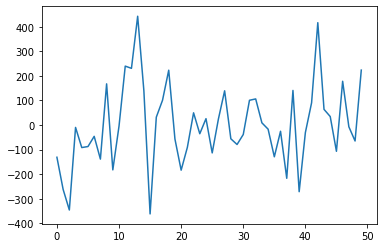

In [120]:
# Define variable to predict
output = 'B441PV_std'
# just plot and show some example data
plt.plot(df.B418PH_data[0])
print(df.B418PH_mean[0])
print(df.B418PH_var[0])

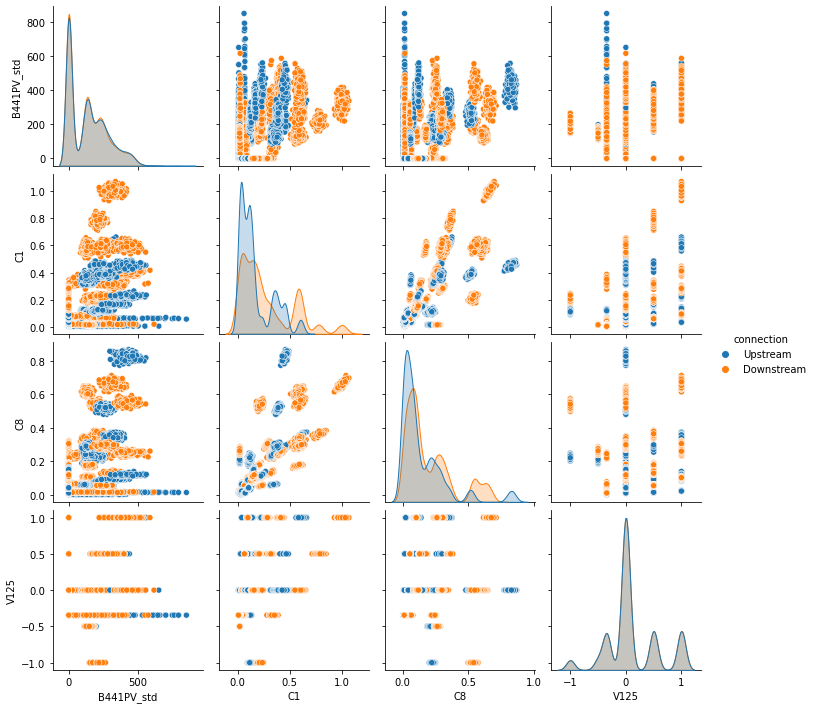

In [121]:
# Just to plot some relationships
sns.pairplot(df[[output, 'C1', 'C8', 'V125', 'connection']], diag_kind='kde', hue='connection')

In [122]:
# Get only 15 columns I care about for this example
df = df[['bunch_charge', 'num_bunches', 'V125', 'H125', 'connection', 'reps', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', output]]
convert_dict = {'bunch_charge': int, 'num_bunches': float, 'reps': float} 
df = df.astype(convert_dict)
df

,bunch_charge,num_bunches,V125,H125,connection,reps,C1,C2,C3,C4,C5,C6,C7,C8,B441PV_std
0,250,50.0,-0.3452,0.5357,Upstream,300.0,0.125787,0.130386,0.523158,0.448682,0.145888,0.057161,0.024682,0.044126,138.656559
1,250,50.0,-0.3452,0.5357,Upstream,300.0,0.124891,0.122449,0.504881,0.429264,0.137149,0.051645,0.022580,0.039295,109.398381
2,250,50.0,-0.3452,0.5357,Upstream,300.0,0.124635,0.120322,0.505017,0.427904,0.136774,0.050708,0.022454,0.038037,112.492225
3,250,50.0,-0.3452,0.5357,Upstream,300.0,0.118786,0.116632,0.478015,0.401456,0.127130,0.045398,0.020581,0.031735,115.484824
4,250,50.0,-0.3452,0.5357,Upstream,300.0,0.133275,0.131215,0.530097,0.450509,0.146080,0.055430,0.024999,0.041351,120.711042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17595,250,1.0,0.0000,-1.0000,Downstream,300.0,0.164531,0.213478,0.194903,0.181066,0.155166,0.128281,0.129489,0.117805,0.000000
17596,250,1.0,0.0000,-1.0000,Downstream,300.0,0.150945,0.206443,0.184874,0.175678,0.150810,0.122212,0.130741,0.113964,0.000000
17597,250,1.0,0.0000,-1.0000,Downstream,300.0,0.144606,0.196726,0.178423,0.168635,0.147421,0.119185,0.127410,0.109986,0.000000
17598,250,1.0,0.0000,-1.0000,Downstream,300.0,0.144625,0.196734,0.177356,0.169459,0.146780,0.120936,0.129253,0.111885,0.000000


In [123]:
# Get only the data I need for this toy example
df = df[df.bunch_charge == 250]
df = df[df.num_bunches == 50]
df = df[df.H125 == 0.0]
df = df[df.connection == 'Upstream']
df

,bunch_charge,num_bunches,V125,H125,connection,reps,C1,C2,C3,C4,C5,C6,C7,C8,B441PV_std
2200,250,50.0,0.0,0.0,Upstream,300.0,0.113871,0.117484,0.064260,0.143868,0.126589,0.086457,0.055663,0.181608,145.684264
2201,250,50.0,0.0,0.0,Upstream,300.0,0.126453,0.132639,0.073059,0.159190,0.140515,0.093193,0.061958,0.197487,139.508992
2202,250,50.0,0.0,0.0,Upstream,300.0,0.118793,0.121865,0.066753,0.147087,0.132378,0.088823,0.058273,0.186219,144.984296
2203,250,50.0,0.0,0.0,Upstream,300.0,0.125912,0.131790,0.075906,0.157550,0.134118,0.089243,0.061570,0.188520,140.962569
2204,250,50.0,0.0,0.0,Upstream,300.0,0.113442,0.116032,0.066224,0.144338,0.128033,0.088431,0.056948,0.180575,168.539298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10695,250,50.0,1.0,0.0,Upstream,300.0,0.618713,0.698679,0.457700,0.644570,0.699183,0.268549,0.223929,0.359092,339.766255
10696,250,50.0,1.0,0.0,Upstream,300.0,0.602116,0.697928,0.447825,0.639325,0.681140,0.265744,0.216323,0.346258,266.296242
10697,250,50.0,1.0,0.0,Upstream,300.0,0.586796,0.664775,0.429804,0.611682,0.668462,0.255245,0.209495,0.340244,356.208224
10698,250,50.0,1.0,0.0,Upstream,300.0,0.612639,0.706315,0.462283,0.651420,0.697175,0.272869,0.223990,0.358250,295.058398


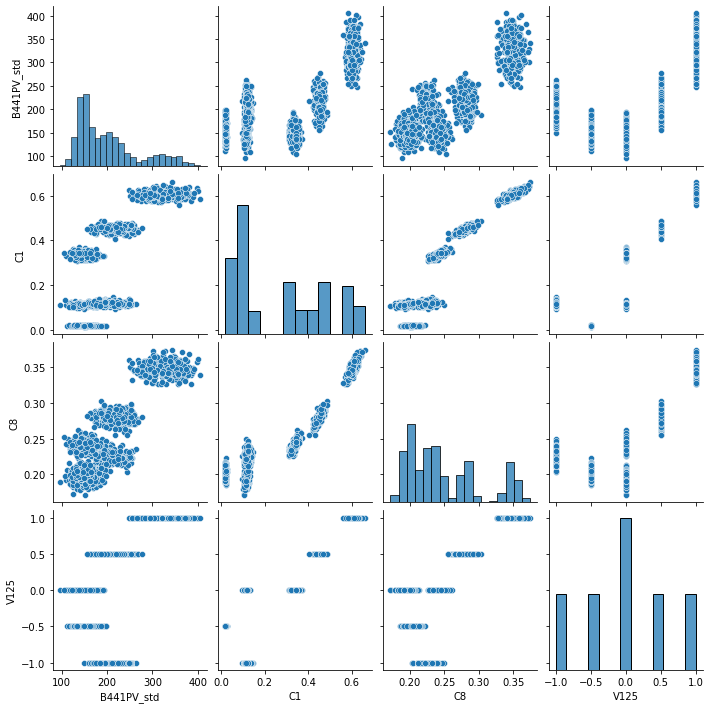

In [124]:
sns.pairplot(df[[output, 'C1', 'C8', 'V125', 'connection']]) #, diag_kind='kde') # Just plot some relationships

In [125]:
# Change to categorical data (Not important for this toy example)
df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['connection'])
df

,bunch_charge,num_bunches,V125,H125,reps,C1,C2,C3,C4,C5,C6,C7,C8,B441PV_std,Upstream
2200,250,50.0,0.0,0.0,300.0,0.113871,0.117484,0.064260,0.143868,0.126589,0.086457,0.055663,0.181608,145.684264,1
2201,250,50.0,0.0,0.0,300.0,0.126453,0.132639,0.073059,0.159190,0.140515,0.093193,0.061958,0.197487,139.508992,1
2202,250,50.0,0.0,0.0,300.0,0.118793,0.121865,0.066753,0.147087,0.132378,0.088823,0.058273,0.186219,144.984296,1
2203,250,50.0,0.0,0.0,300.0,0.125912,0.131790,0.075906,0.157550,0.134118,0.089243,0.061570,0.188520,140.962569,1
2204,250,50.0,0.0,0.0,300.0,0.113442,0.116032,0.066224,0.144338,0.128033,0.088431,0.056948,0.180575,168.539298,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10695,250,50.0,1.0,0.0,300.0,0.618713,0.698679,0.457700,0.644570,0.699183,0.268549,0.223929,0.359092,339.766255,1
10696,250,50.0,1.0,0.0,300.0,0.602116,0.697928,0.447825,0.639325,0.681140,0.265744,0.216323,0.346258,266.296242,1
10697,250,50.0,1.0,0.0,300.0,0.586796,0.664775,0.429804,0.611682,0.668462,0.255245,0.209495,0.340244,356.208224,1
10698,250,50.0,1.0,0.0,300.0,0.612639,0.706315,0.462283,0.651420,0.697175,0.272869,0.223990,0.358250,295.058398,1


In [126]:
# Split into train and test datasets
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)
train_dataset.info()
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 4697 to 8244
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bunch_charge  1440 non-null   int64  
 1   num_bunches   1440 non-null   float64
 2   V125          1440 non-null   float64
 3   H125          1440 non-null   float64
 4   reps          1440 non-null   float64
 5   C1            1440 non-null   float64
 6   C2            1440 non-null   float64
 7   C3            1440 non-null   float64
 8   C4            1440 non-null   float64
 9   C5            1440 non-null   float64
 10  C6            1440 non-null   float64
 11  C7            1440 non-null   float64
 12  C8            1440 non-null   float64
 13  B441PV_std    1440 non-null   float64
 14  Upstream      1440 non-null   uint8  
dtypes: float64(13), int64(1), uint8(1)
memory usage: 170.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 2211 to 10694
Data columns (total

In [127]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bunch_charge,1440.0,250.000000,0.000000,250.000000,250.000000,250.000000,250.000000,250.000000
num_bunches,1440.0,50.000000,0.000000,50.000000,50.000000,50.000000,50.000000,50.000000
V125,1440.0,-0.003125,0.652272,-1.000000,-0.500000,0.000000,0.500000,1.000000
H125,1440.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
reps,1440.0,300.000000,0.000000,300.000000,300.000000,300.000000,300.000000,300.000000
C1,1440.0,0.276087,0.207398,0.016376,0.112186,0.313158,0.452049,0.662376
C2,1440.0,0.317925,0.239365,0.018803,0.120659,0.362570,0.527969,0.756896
C3,1440.0,0.214838,0.160646,0.022987,0.069977,0.276764,0.356059,0.485743
C4,1440.0,0.313155,0.196670,0.083003,0.132046,0.342486,0.474651,0.685687
C5,1440.0,0.309118,0.217474,0.045059,0.132860,0.291434,0.486716,0.734674


In [128]:
# Split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop(output)
test_labels = test_features.pop(output)

In [129]:
# The Normalization Layer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())
print(normalizer.variance.numpy())

[[ 2.5000000e+02  5.0000000e+01 -3.1250017e-03  0.0000000e+00
   3.0000000e+02  2.7608699e-01  3.1792501e-01  2.1483847e-01
   3.1315538e-01  3.0911791e-01  1.4989385e-01  1.1617317e-01
   2.4922146e-01  1.0000000e+00]]
[[1.6453366e-09 1.1576859e-10 4.2516392e-01 0.0000000e+00 6.0018563e-09
  4.2983964e-02 5.7255782e-02 2.5789130e-02 3.8652111e-02 4.7261987e-02
  3.3870325e-03 2.9567296e-03 2.8171604e-03 0.0000000e+00]]


First example: [[250.    50.    -1.     0.   300.     0.12   0.15   0.08   0.14   0.18
    0.13   0.11   0.23   1.  ]]

Normalized: [[ 0.    0.   -1.53  0.    0.   -0.73 -0.71 -0.85 -0.9  -0.58 -0.28 -0.09
  -0.33  0.  ]]


array([[<AxesSubplot:title={'center':'C1'}>]], dtype=object)

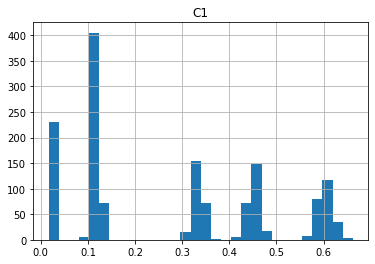

In [130]:
# Original vs normalized
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

train_features.hist('C1', bins=30)

(array([231.,   0.,   0.,   6., 405.,  71.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  15., 155.,  71.,   2.,   0.,   6.,  71., 148.,  17.,
          0.,   0.,   0.,   8.,  79., 117.,  34.,   4.]),
 array([-1.2526711 , -1.1488088 , -1.0449466 , -0.94108427, -0.837222  ,
        -0.7333597 , -0.6294974 , -0.5256351 , -0.42177284, -0.31791055,
        -0.21404827, -0.11018598, -0.0063237 ,  0.09753859,  0.20140088,
         0.30526316,  0.40912545,  0.51298773,  0.61685   ,  0.7207123 ,
         0.8245746 ,  0.9284369 ,  1.0322992 ,  1.1361614 ,  1.2400237 ,
         1.343886  ,  1.4477483 ,  1.5516106 ,  1.6554729 ,  1.7593352 ,
         1.8631974 ], dtype=float32),
 <BarContainer object of 30 artists>)

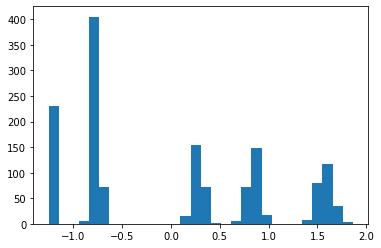

In [131]:
train_features_norm = normalizer(train_features)
tf_norm = train_features_norm.numpy()
plt.hist(tf_norm[:,5], bins=30)

In [132]:
# Linear Regression
# Lets train a linear model based only on one variable (C1)
# Normalization layer
c1 = np.array(train_features['C1'])
print(c1)
print(len(c1))
c1_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
c1_normalizer.adapt(c1)
print(c1_normalizer.mean.numpy())
print(c1_normalizer.variance.numpy())

first = np.array(c1[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print('Normalized:', c1_normalizer(first).numpy())

[0.12417512 0.01931004 0.32215636 ... 0.446538   0.32513592 0.45695634]
1440
[0.27608696]
[0.04298396]
First example: [0.12]
Normalized: [-0.73]


In [133]:
# Build keras sequential model
c1_model = tf.keras.Sequential([
    c1_normalizer,
    layers.Dense(units=1)
])

c1_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_11 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [134]:
# Configure the training of the model
c1_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.5),
    loss='mean_absolute_error',
    metrics=['mean_squared_error', 'mean_absolute_percentage_error'])

In [135]:
%%time
# Execute the training
early_stop =EarlyStopping(monitor='val_loss', min_delta=0.1, patience=50)
history = c1_model.fit(
    train_features['C1'], train_labels,
    epochs=1000,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2,
    callbacks=[early_stop])

CPU times: user 3.46 s, sys: 422 ms, total: 3.88 s
Wall time: 2.81 s


In [136]:
# Get the training process numbers
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,mean_absolute_percentage_error,val_loss,val_mean_squared_error,val_mean_absolute_percentage_error,epoch
65,36.902691,2080.357178,19.451771,36.169815,2032.205566,18.778236,65
66,36.879379,2076.842773,19.438955,36.190063,2022.201172,18.829826,66
67,36.902096,2069.764648,19.513834,36.185585,2023.717896,18.818958,67
68,36.904198,2082.038818,19.495350,36.177414,2023.822266,18.825615,68
69,36.906387,2086.528320,19.468859,36.197243,2026.662964,18.789833,69


In [198]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.ylim([0, 50])
  plt.legend()
  plt.grid(True)

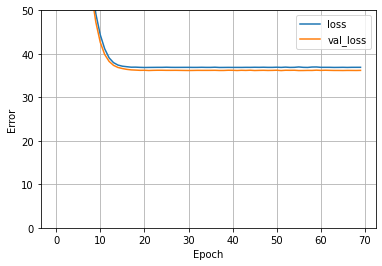

In [138]:
plot_loss(history)

In [139]:
# Evaluate using the test dataset
test_results = {}

test_results['c1_model'] = c1_model.evaluate(
    test_features['C1'],
    test_labels, verbose=0)

In [140]:
test_results['c1_model']

[34.138526916503906, 1769.4678955078125, 18.578533172607422]

In [141]:
# make predictions using the trained model
x = tf.linspace(0.0, 1, 251)
y = c1_model.predict(x)

In [142]:
# function to compare predictions vs data
def plot_c1(x, y):
  plt.scatter(train_features['C1'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('C1')
  plt.ylabel(output)
  plt.legend()

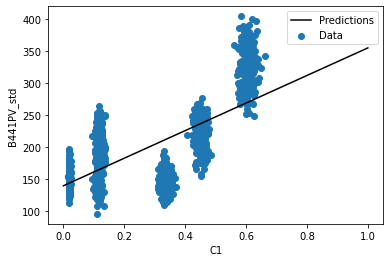

In [143]:
plot_c1(x,y)

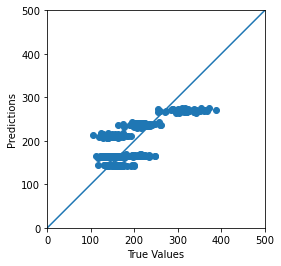

In [144]:
# Predictions vs labels
test_predictions_c1_model = c1_model.predict(test_features[['C1']]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions_c1_model)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 500]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

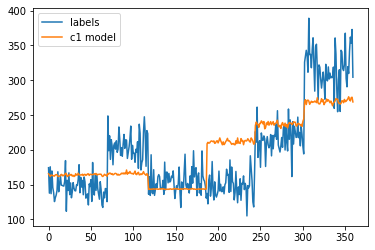

In [145]:
# Plot test labels and test predictiones vs sample #
plt.plot(np.array(test_labels), label='labels')
plt.plot(np.array(test_predictions_c1_model), label='c1 model')
plt.legend()

In [146]:
# Linear Regression
# Let's do now multiple inputs 
# Normalization layer
normalizer_array = np.array(train_features[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'V125']])
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(normalizer_array))
print(normalizer.mean.numpy())
print(normalizer.variance.numpy())

first = np.array(normalizer_array[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print('Normalized:', normalizer(first).numpy())

[[ 0.276087    0.317925    0.21483847  0.31315538  0.3091179   0.14989385
   0.11617317  0.24922146 -0.003125  ]]
[[0.04298396 0.05725578 0.02578913 0.03865211 0.04726199 0.00338703
  0.00295673 0.00281716 0.42516392]]
First example: [[ 0.12  0.15  0.08  0.14  0.18  0.13  0.11  0.23 -1.  ]]
Normalized: [[-0.73 -0.71 -0.85 -0.9  -0.58 -0.28 -0.09 -0.33 -1.53]]


In [147]:
# Build keras sequential model
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
linear_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_12 (Normalizat (None, 9)                 19        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 10        
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [148]:
linear_model.predict(normalizer_array[:10])

array([[ 0.4091898 ],
       [ 0.50866807],
       [ 0.32971692],
       [ 0.48908496],
       [-1.6047411 ],
       [ 0.35324758],
       [-1.5380685 ],
       [ 0.5759795 ],
       [ 0.47334567],
       [-1.593863  ]], dtype=float32)

In [149]:
# Configure the training of the model
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.5),
    loss='mean_absolute_error',
    metrics=['mean_squared_error', 'mean_absolute_percentage_error'])

In [150]:
%%time
# Execute the training
early_stop =EarlyStopping(monitor='val_loss', min_delta=0.1, patience=50)
history = linear_model.fit(
    normalizer_array, train_labels, 
    epochs=1000,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2,
    callbacks=[early_stop])

CPU times: user 4.69 s, sys: 571 ms, total: 5.26 s
Wall time: 3.74 s


In [151]:
# Get the training process numbers
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mean_squared_error,mean_absolute_percentage_error,val_loss,val_mean_squared_error,val_mean_absolute_percentage_error,epoch
0,190.984818,41400.839844,94.958031,185.472580,40482.703125,89.260475,0
1,172.505981,36211.363281,83.424469,167.931305,35271.515625,78.980232,1
2,154.361603,33715.000000,71.091515,151.616928,34600.832031,67.190414,2
3,136.113541,31271.066406,59.421352,134.522903,31681.070312,56.903206,3
4,118.832726,25909.273438,50.563148,115.148872,21111.412109,49.848606,4
...,...,...,...,...,...,...,...
94,16.399244,460.148560,8.322723,18.506832,574.582275,9.099813,94
95,16.596703,469.672516,8.479478,18.539358,572.462036,9.146447,95
96,16.435781,458.210297,8.311802,18.308361,559.271790,8.997327,96
97,16.503494,464.924652,8.382937,18.511091,570.856750,9.140333,97


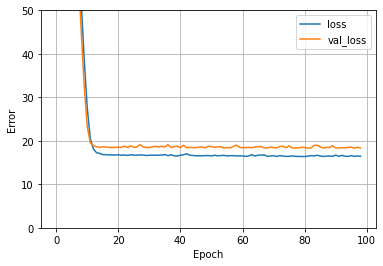

In [152]:
plot_loss(history)

In [153]:
# Evaluate using the test dataset
test_results['linear_model'] = linear_model.evaluate(
    test_features[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'V125']], test_labels, verbose=0)

test_results

{'c1_model': [34.138526916503906, 1769.4678955078125, 18.578533172607422],
 'linear_model': [15.105487823486328, 388.0938415527344, 8.056548118591309]}

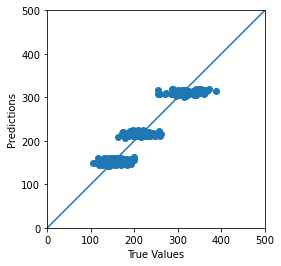

In [154]:
test_predictions_linear_model = linear_model.predict(test_features[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'H125']]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions_linear_model)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 500]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

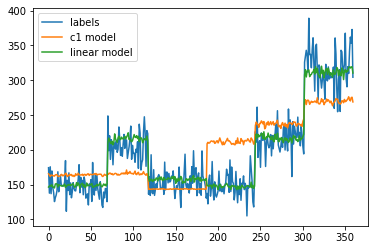

In [155]:
# Plot test labels and test predictiones vs sample #
plt.plot(np.array(test_labels), label='labels')
plt.plot(np.array(test_predictions_c1_model), label='c1 model')
plt.plot(np.array(test_predictions_linear_model), label='linear model')
plt.legend()

In [193]:
# Now let's use a DNN
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='tanh'),
      layers.Dense(64, activation='tanh'),
      layers.Dense(64, activation='tanh'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
               metrics=['mean_squared_error', 'mean_absolute_percentage_error'])
  return model

In [157]:
# Start with one variable
dnn_c1_model = build_and_compile_model(c1_normalizer)

In [158]:
dnn_c1_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_11 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 8,516
Trainable params: 8,513
Non-trainable params: 3
_________________________________________________________________


In [159]:
%%time
# Execute the training
early_stop =EarlyStopping(monitor='val_loss', min_delta=0.1, patience=100)
history = dnn_c1_model.fit(
    train_features['C1'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=10000,
    callbacks=[early_stop])

CPU times: user 1min 51s, sys: 16.1 s, total: 2min 7s
Wall time: 1min 8s


In [160]:
# Get the training process numbers
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,mean_absolute_percentage_error,val_loss,val_mean_squared_error,val_mean_absolute_percentage_error,epoch
1199,20.427958,742.689819,10.626482,20.188894,687.373108,10.137821,1199
1200,20.386560,743.217957,10.581681,20.232897,703.910400,10.077111,1200
1201,20.649775,759.324097,10.788590,20.202520,701.457397,10.074250,1201
1202,20.610155,767.337158,10.641309,20.212811,717.717041,9.981688,1202
1203,20.632029,762.711853,10.787243,20.191618,721.755859,9.918425,1203


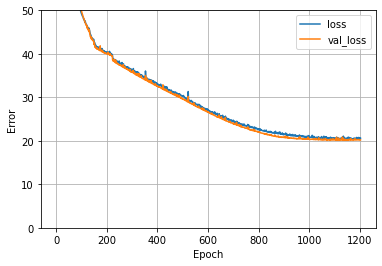

In [161]:
plot_loss(history)

In [162]:
# Evaluate using the test dataset
test_results['dnn_c1_model'] = dnn_c1_model.evaluate(
    test_features['C1'], test_labels,
    verbose=0)

test_results

{'c1_model': [34.138526916503906, 1769.4678955078125, 18.578533172607422],
 'linear_model': [15.105487823486328, 388.0938415527344, 8.056548118591309],
 'dnn_c1_model': [18.1252384185791, 588.715576171875, 9.715200424194336]}

In [163]:
# make predictions using the trained model
x = tf.linspace(0.0, 0.7, 251)
y = dnn_c1_model.predict(x)

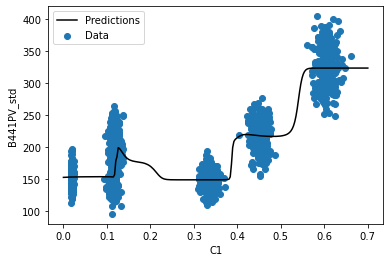

In [164]:
plot_c1(x,y)

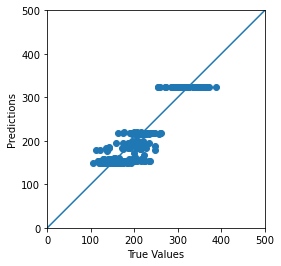

In [165]:
test_predictions_dnn_c1_model = dnn_c1_model.predict(test_features[['C1']]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions_dnn_c1_model)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 500]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

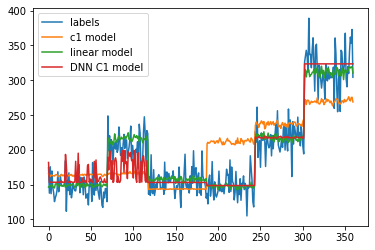

In [166]:
# Plot test labels and test predictiones vs sample #
plt.plot(np.array(test_labels), label='labels')
plt.plot(np.array(test_predictions_c1_model), label='c1 model')
plt.plot(np.array(test_predictions_linear_model), label='linear model')
plt.plot(np.array(test_predictions_dnn_c1_model), label='DNN C1 model')
plt.legend()

In [194]:
# Now lets do the full model
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_12 (Normalizat (None, 9)                 19        
_________________________________________________________________
dense_28 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 9,044
Trainable params: 9,025
Non-trainable params: 19
_________________________________________________________________


In [195]:
%%time
# Execute the training
early_stop =EarlyStopping(monitor='val_loss', min_delta=0.1, patience=300)
history = dnn_model.fit(
    normalizer_array, train_labels,
    validation_split=0.2,
    verbose=0, epochs=10000,
    callbacks=[early_stop])

CPU times: user 1min 1s, sys: 10.4 s, total: 1min 12s
Wall time: 38 s


In [196]:
# Get the training process numbers
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,mean_absolute_percentage_error,val_loss,val_mean_squared_error,val_mean_absolute_percentage_error,epoch
656,15.748469,431.103668,7.983640,18.099096,532.466370,8.905833,656
657,15.734646,429.854309,7.983498,18.153891,533.776550,8.938877,657
658,15.760472,431.264099,8.021309,18.074457,532.099854,8.899853,658
659,15.751942,431.327972,7.991124,18.089239,532.283997,8.889260,659
660,15.764958,431.723572,8.004522,18.135265,534.617493,8.913605,660


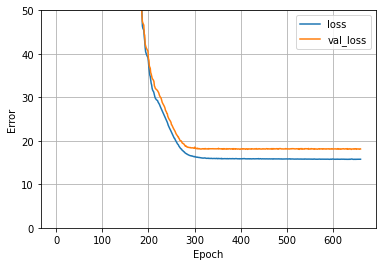

In [199]:
plot_loss(history)

In [200]:
# Evaluate using the test dataset
test_results['dnn_model'] = dnn_model.evaluate(test_features[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'V125']], 
                                               test_labels, verbose=0)
test_results

{'c1_model': [34.138526916503906, 1769.4678955078125, 18.578533172607422],
 'linear_model': [15.105487823486328, 388.0938415527344, 8.056548118591309],
 'dnn_c1_model': [18.1252384185791, 588.715576171875, 9.715200424194336],
 'dnn_model': [15.16621208190918, 396.5353698730469, 7.997048377990723]}

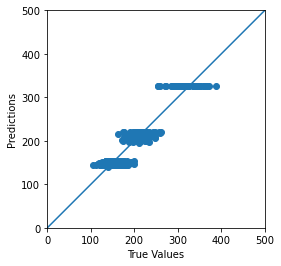

In [201]:
test_predictions_dnn_model = dnn_model.predict(test_features[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'V125']]).flatten()
a = plt.axes(aspect='equal') 
plt.scatter(test_labels, test_predictions_dnn_model) 
plt.xlabel('True Values') 
plt.ylabel('Predictions') 
lims = [0, 500] 
plt.xlim(lims) 
plt.ylim(lims) 
_ = plt.plot(lims, lims)

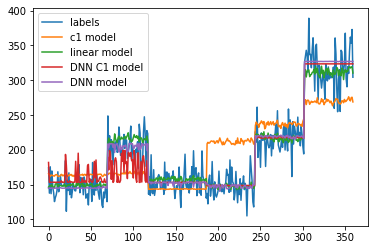

In [202]:
# Plot test labels and test predictiones vs sample #
plt.plot(np.array(test_labels), label='labels')
plt.plot(np.array(test_predictions_c1_model), label='c1 model')
plt.plot(np.array(test_predictions_linear_model), label='linear model')
plt.plot(np.array(test_predictions_dnn_c1_model), label='DNN C1 model')
plt.plot(np.array(test_predictions_dnn_model), label='DNN model')
plt.legend()

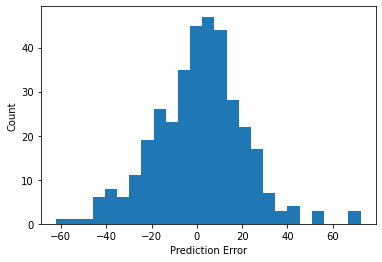

In [203]:
error = test_predictions_dnn_model - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

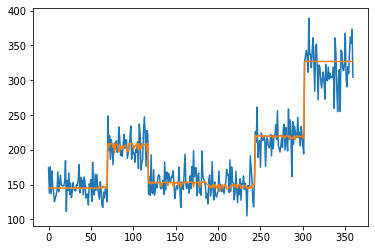

In [204]:
plt.plot(np.array(test_labels))
plt.plot(np.array(test_predictions_dnn_model))

In [205]:
# Let's compare the test results of the models
pd.DataFrame(test_results, index=['Mean absolute error', 'mean_squared_error', 'mean_absolute_percentage_error']).T

,Mean absolute error,mean_squared_error,mean_absolute_percentage_error
c1_model,34.138527,1769.467896,18.578533
linear_model,15.105488,388.093842,8.056548
dnn_c1_model,18.125238,588.715576,9.715200
dnn_model,15.166212,396.535370,7.997048
